<div class="alert alert-success" style = "border-radius: 20px;text-align: center;" role="alert">
    Don't forget to upvote if you liked the notebook
</div>

Citation: this notebook is taken from andrew's CNN course program exercise
Link of Course: https://www.coursera.org/learn/convolutional-neural-networks?specialization=deep-learning

# Table of Contents

- [1 - Importing libraries](#1)
- [2 - Loading Pretrained Facenet Model](#2)
- [3 - Triplet Loss Function](#3)
- [4 - Function to preprocess images and predict them](#4)
- [5 - Simulation of a Database](#5)
- [6 - Face Verification](#6)
- [7 - Face Recognition](#7)

<a name='1'></a>
# 1 - Importing libraries

In [1]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D, AveragePooling2D
from keras.layers import Concatenate
from keras.layers import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.layers import Layer
from keras import backend as K
K.set_image_data_format('channels_last')
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import PIL

%matplotlib inline
%load_ext autoreload
%autoreload 2

2024-07-09 09:08:15.179716: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<a name='2'></a>
# 2 - Loading Pretrained Facenet Model

In [6]:
# from tensorflow.keras.models import model_from_json
# model = tf.keras.models.load_model('/kaggle/input/files-for-face-verification-and-recognition/model')
layer = keras.layers.TFSMLayer('model/', call_endpoint="serving_default")
model = keras.Sequential([layer])

Now summarize the input and output shapes:

In [66]:
print(model.inputs)
print(model.outputs)

[<KerasTensor shape=(1, 160, 160, 3), dtype=float32, sparse=None, name=keras_tensor>]
[<KerasTensor shape=(1, 128), dtype=float32, sparse=False, name=keras_tensor_1>]


<a name='3'></a>
# 3 - Triplet Loss Function

It's already implemented in the pretrained model but just to show you how it's built

In [8]:
def triplet_loss(y_true, y_pred, alpha = 0.2):

    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]

    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0))

    return loss

In [9]:
FRmodel = model

<a name='4'></a>
# 4 - Function to preprocess images and predict them

In [50]:
def img_to_encoding(image_path, model):
    img = keras.preprocessing.image.load_img(image_path, target_size=(160, 160))
    img = np.around(np.array(img) / 255.0, decimals=12)

    x_train = np.expand_dims(img, axis=0) # add a dimension of 1 as first dimension
    embedding = model.predict_on_batch(x_train)
    mag = np.linalg.norm(embedding["Bottleneck_BatchNorm"][0])
    return embedding["Bottleneck_BatchNorm"] / mag

<a name='5'></a>
# 5 - Simulation of a Database

In [68]:
database = {}
database["josh"] = img_to_encoding("images/josh.jpg", FRmodel)
database["danielle"] = img_to_encoding("images/danielle.png", FRmodel)
database["younes"] = img_to_encoding("images/younes.jpg", FRmodel)
database["tian"] = img_to_encoding("images/tian.jpg", FRmodel)
database["andrew"] = img_to_encoding("images/andrew.jpg", FRmodel)
database["kian"] = img_to_encoding("images/kian.jpg", FRmodel)
database["dan"] = img_to_encoding("images/dan.jpg", FRmodel)
database["sebastiano"] = img_to_encoding("images/sebastiano.jpg", FRmodel)
database["bertrand"] = img_to_encoding("images/bertrand.jpg", FRmodel)
database["kevin"] = img_to_encoding("images/kevin.jpg", FRmodel)
database["felix"] = img_to_encoding("images/felix.jpg", FRmodel)
database["benoit"] = img_to_encoding("images/benoit.jpg", FRmodel)
database["arnaud"] = img_to_encoding("images/arnaud.jpg", FRmodel)

Load the images of Danielle and Kian:

In [69]:
danielle = keras.preprocessing.image.load_img("images/danielle.png", target_size=(160, 160))
kian = keras.preprocessing.image.load_img("images/kian.jpg", target_size=(160, 160))
josh = keras.preprocessing.image.load_img("images/josh.jpg", target_size=(160, 160))

In [55]:
np.around(np.array(kian) / 255.0, decimals=12).shape

(160, 160, 3)

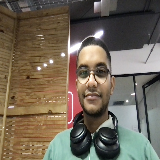

In [70]:
josh

In [57]:
np.around(np.array(danielle) / 255.0, decimals=12).shape

(160, 160, 3)

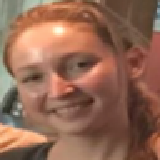

In [58]:
danielle

<a name='6'></a>
# 6 - Face Verification

In [59]:
def verify(image_path, identity, database, model):
    
    encoding = img_to_encoding(image_path, model)
    dist = np.linalg.norm(tf.subtract(database[identity], encoding))
    if dist < 0.7:
        print("It's " + str(identity) + ", welcome in!")
        door_open = True
    else:
        print("It's not " + str(identity) + ", please go away")
        door_open = False
    return dist, door_open

Younes is trying to enter the office and the camera takes a picture of him ("images/camera_0.jpg"). Let's run your verification algorithm on this picture:

<img src="https://drive.google.com/uc?id=1DeuZSJf8fxqevYTY2G1AluTiZxL8V7bk" style="width:100px;height:100px;">

In [72]:
distance, door_open_flag = verify("images/photo.jpg", "younes", database, FRmodel)
print("(", distance, ",", door_open_flag, ")")
distance, door_open_flag = verify("images/photo.jpg", "josh", database, FRmodel)
print("(", distance, ",", door_open_flag, ")")
distance, door_open_flag = verify("images/photo0.jpg", "josh", database, FRmodel)
print("(", distance, ",", door_open_flag, ")")

It's not younes, please go away
( 1.3761865 , False )
It's not josh, please go away
( 0.7077273 , False )
It's josh, welcome in!
( 0.38399905 , True )


Benoit, who does not work in the office, stole Kian's ID card and tried to enter the office. Naughty Benoit! The camera took a picture of Benoit ("images/camera_2.jpg).

<img src="https://drive.google.com/uc?id=1FkoH2Bdku4Hi3vQVB6uEgNmZ6JKdjECX" style="width:100px;height:100px;">

Run the verification algorithm to check if Benoit can enter.

In [63]:
verify("images/camera_2.jpg", "kian", database, FRmodel)

It's not kian, please go away


(1.0130049, False)

<a name='7'></a>
# 7 - Face Recognition

In [64]:
def who_is_it(image_path, database, model):
    
    encoding =  img_to_encoding(image_path, model)

    min_dist = 100

    for (name, db_enc) in database.items():

        dist = np.linalg.norm(tf.subtract(db_enc, encoding))

        if dist < min_dist:
            min_dist = dist
            identity = name

    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))

    return min_dist, identity

Younes is at the front door and the camera takes a picture of him ("images/camera_0.jpg"). Let's see if your `who_it_is()` algorithm identifies Younes.

In [65]:

# Test 1 with Younes pictures
who_is_it("images/camera_0.jpg", database, FRmodel)

# Test 2 with Younes pictures
test1 = who_is_it("images/camera_0.jpg", database, FRmodel)

# Test 3 with Younes pictures
test2 = who_is_it("images/younes.jpg", database, FRmodel)

it's younes, the distance is 0.6019791
it's younes, the distance is 0.6019791
it's younes, the distance is 0.0


**Ways to improve your facial recognition model**:

Although you won't implement these here, here are some ways to further improve the algorithm:

- Put more images of each person (under different lighting conditions, taken on different days, etc.) into the database. Then, given a new image, compare the new face to multiple pictures of the person. This would increase accuracy.

- Crop the images to contain just the face, and less of the "border" region around the face. This preprocessing removes some of the irrelevant pixels around the face, and also makes the algorithm more robust.